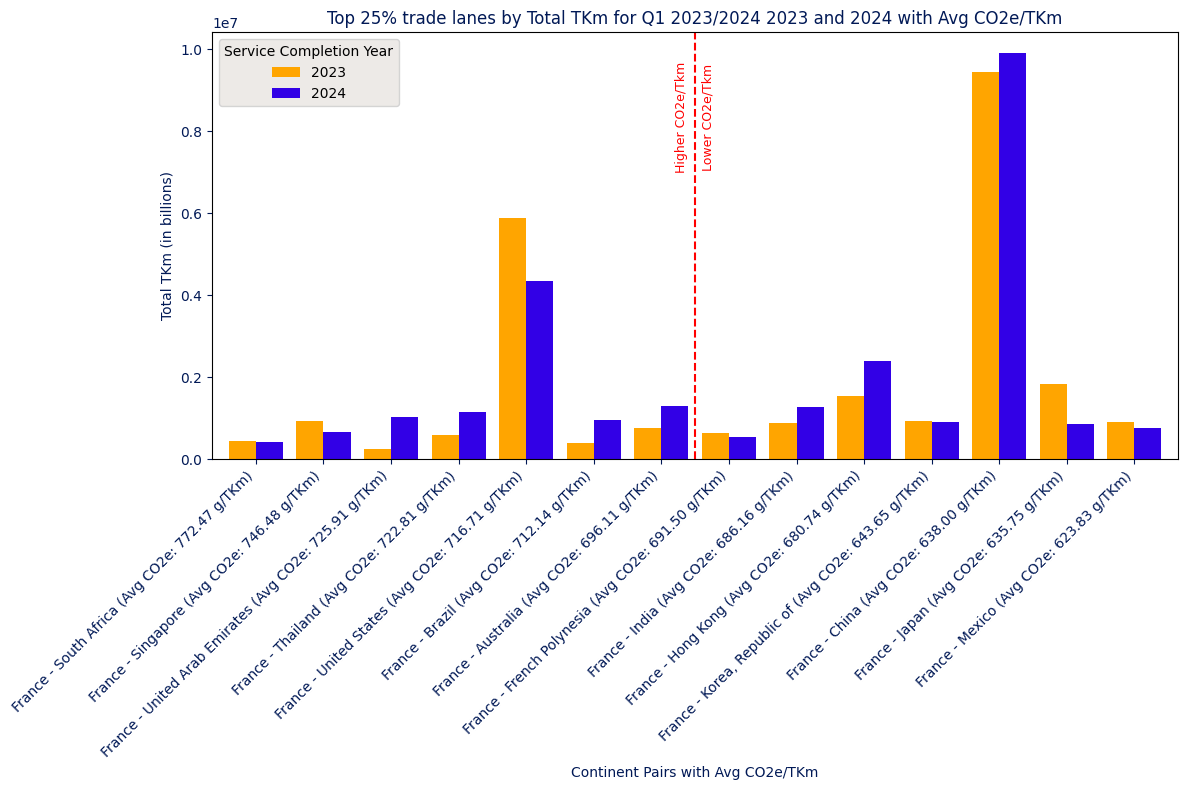

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# Load the Excel file
df = pd.read_excel('franceAirc.xlsx')
month = "Q1 2023/2024"

# Ensure 'TKm' and 'CO2eq/TKm (g)' are treated as numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq/TKm (g)'] = pd.to_numeric(df['CO2eq/TKm (g)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')

# Group data by year and continent pairs to calculate total TKm for each pair
stats_by_pair = df.groupby(['Origin Continent', 'Destination Continent']).agg(
    Total_TKm=('TKm', 'sum'),
    Avg_CO2eq_TKm=('CO2eq/TKm (g)', 'mean')  # Calculate the average CO2eq/TKm for each pair
).reset_index()

# Determine the top 25% threshold for the total TKm
threshold = stats_by_pair['Total_TKm'].quantile(0.9)

# Create a boolean mask for the top 25% continent pairs
top_25_mask = stats_by_pair['Total_TKm'] > threshold

# Use loc to avoid SettingWithCopyWarning
stats_by_pair.loc[top_25_mask, 'Label'] = stats_by_pair.loc[top_25_mask].apply(
    lambda x: f"{x['Origin Continent']} - {x['Destination Continent']} (Avg CO2e: {x['Avg_CO2eq_TKm']:.2f} g/TKm)", axis=1)

# Merge the label and CO2eq information back to the original dataframe
df = df.merge(stats_by_pair[['Origin Continent', 'Destination Continent', 'Label', 'Avg_CO2eq_TKm']], 
              on=['Origin Continent', 'Destination Continent'], 
              how='left')

# Filter out rows that didn't get any label (not in the top 25%)
df_labeled = df[df['Label'].notna()]

# Group by the new label and service year for plotting
pivot_data = df_labeled.groupby(['Service Completion Year', 'Label']).agg(
    Total_TKm=('TKm', 'sum')
).reset_index()

# Create a sorted list of labels based on Avg_CO2eq_TKm
sorted_labels = df_labeled.dropna(subset=['Label']).groupby('Label')['Avg_CO2eq_TKm'].mean().sort_values(ascending=False).index

# Reorder the pivot table based on sorted labels
pivot_table = pivot_data.pivot_table(index='Label', columns='Service Completion Year', values='Total_TKm', aggfunc='sum').loc[sorted_labels].fillna(0)

# ...

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot(kind='bar', ax=ax, color={2023: 'orange', 2024: '#3200E6'}, width=0.8)
plt.title(f'Top 25% trade lanes by Total TKm for {month} 2023 and 2024 with Avg CO2e/TKm')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(colors='#011956')
ax.xaxis.label.set_color('#011956')
ax.yaxis.label.set_color('#011956')
ax.title.set_color('#011956')

plt.ylabel('Total TKm (in billions)')
plt.xlabel('Continent Pairs with Avg CO2e/TKm')
plt.xticks(rotation=45, ha='right')

# Draw a line to separate high and low CO2eq/Tkm and adjust labels
median_index = len(pivot_table) // 2
plt.axvline(x=median_index - 0.5, color='red', linestyle='--')

# Move the text labels down
text_position = ax.get_ylim()[1] * 0.8  # Adjust the 0.8 as needed to move the text up or down

ax.text(median_index - 0.6, text_position, 'Higher CO2e/Tkm', ha='right', va='center', rotation='vertical', color='red', fontsize=9)
ax.text(median_index - 0.4, text_position, 'Lower CO2e/Tkm', ha='left', va='center', rotation='vertical', color='red', fontsize=9)

plt.legend(title='Service Completion Year', facecolor='#E9E5E2')
plt.tight_layout()

plt.show()



In [9]:
import pandas as pd

# Load the data
df = pd.read_excel('franceAirc.xlsx')

# Ensure 'TKm' and 'CO2eq/TKm (g)' are numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq/TKm (g)'] = pd.to_numeric(df['CO2eq/TKm (g)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['Total_CO2eq'] = df['TKm'] * df['CO2eq/TKm (g)']

# Define a function to calculate total TKm and total CO2eq for each year
def calculate_totals_by_year(df, year):
    filtered_df = df[df['Service Completion Year'] == year]
    total_TKm = filtered_df['TKm'].sum()
    total_CO2eq = filtered_df['Total_CO2eq'].sum()
    return total_TKm, total_CO2eq

# Calculate efficiency for each year
total_TKm_2023, total_CO2eq_2023 = calculate_totals_by_year(df, 2023)
total_TKm_2024, total_CO2eq_2024 = calculate_totals_by_year(df, 2024)

efficiency_2023 = total_CO2eq_2023 / total_TKm_2023
efficiency_2024 = total_CO2eq_2024 / total_TKm_2024

# Determine the median CO2eq/TKm for 2023 to classify trade lanes into high and low CO2eq/TKm
median_CO2eq_2023 = df[df['Service Completion Year'] == 2023]['CO2eq/TKm (g)'].median()

# Calculate the expected 2024 CO2eq/TKm assuming 2023 trade patterns but applying 2024 efficiency
# Split 2023 data into high and low CO2eq/TKm lanes
high_CO2eq_lanes_2023 = df[(df['Service Completion Year'] == 2023) & (df['CO2eq/TKm (g)'] > median_CO2eq_2023)]
low_CO2eq_lanes_2023 = df[(df['Service Completion Year'] == 2023) & (df['CO2eq/TKm (g)'] <= median_CO2eq_2023)]

# Calculate the weighted average CO2eq/TKm for high and low lanes in 2024
high_lanes_CO2eq_2024 = high_CO2eq_lanes_2023['CO2eq/TKm (g)'].mean()
low_lanes_CO2eq_2024 = low_CO2eq_lanes_2023['CO2eq/TKm (g)'].mean()

# Estimate the expected 2024 CO2eq using 2023 volumes but 2024 lane efficiencies
expected_CO2eq_2024 = (high_CO2eq_lanes_2023['TKm'].sum() * high_lanes_CO2eq_2024) + (low_CO2eq_lanes_2023['TKm'].sum() * low_lanes_CO2eq_2024)

# Calculate the expected 2024 efficiency
expected_efficiency_2024 = expected_CO2eq_2024 / total_TKm_2024

# Calculate the percentage difference between actual and expected efficiency
efficiency_change_pct = ((efficiency_2024 - expected_efficiency_2024) / expected_efficiency_2024) * 100

print(f"Actual 2024 CO2eq/TKm efficiency: {efficiency_2024:.2f}")
print(f"Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): {expected_efficiency_2024:.2f}")
print(f"Percentage change in CO2eq/TKm efficiency attributed to shifts in trade patterns: {efficiency_change_pct:.2f}%")

# Interpretation
if efficiency_change_pct > 0:
    print("The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.")
else:
    print("The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.")



Actual 2024 CO2eq/TKm efficiency: 697.10
Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): 688.97
Percentage change in CO2eq/TKm efficiency attributed to shifts in trade patterns: 1.18%
The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.


In [10]:
# Correct the interpretation for positive and negative changes
if efficiency_change_pct > 0:
    print("The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.")
else:
    print("The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.")

# Calculate the total change in CO2eq/TKm efficiency from 2023 to 2024
total_efficiency_change_pct = ((efficiency_2024 - efficiency_2023) / efficiency_2023) * 100

# Calculate the portion of the change not attributed to trade patterns
non_trade_pattern_change = total_efficiency_change_pct - efficiency_change_pct

print(f"Total change in CO2eq/TKm efficiency from 2023 to 2024: {total_efficiency_change_pct:.2f}%")
print(f"Change not attributed to trade patterns: {non_trade_pattern_change:.2f}%")

# Updated Interpretation based on corrected perspective
if efficiency_change_pct < 0:
    # Note: A negative percentage now indicates a decrease in CO2eq/TKm, which is positive in environmental terms
    print("Shifts in trade patterns have contributed to an improvement in CO2eq/TKm efficiency.")
else:
    print("Shifts in trade patterns have contributed to a decrease in CO2eq/TKm efficiency.")


The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.
Total change in CO2eq/TKm efficiency from 2023 to 2024: 4.15%
Change not attributed to trade patterns: 2.97%
Shifts in trade patterns have contributed to a decrease in CO2eq/TKm efficiency.


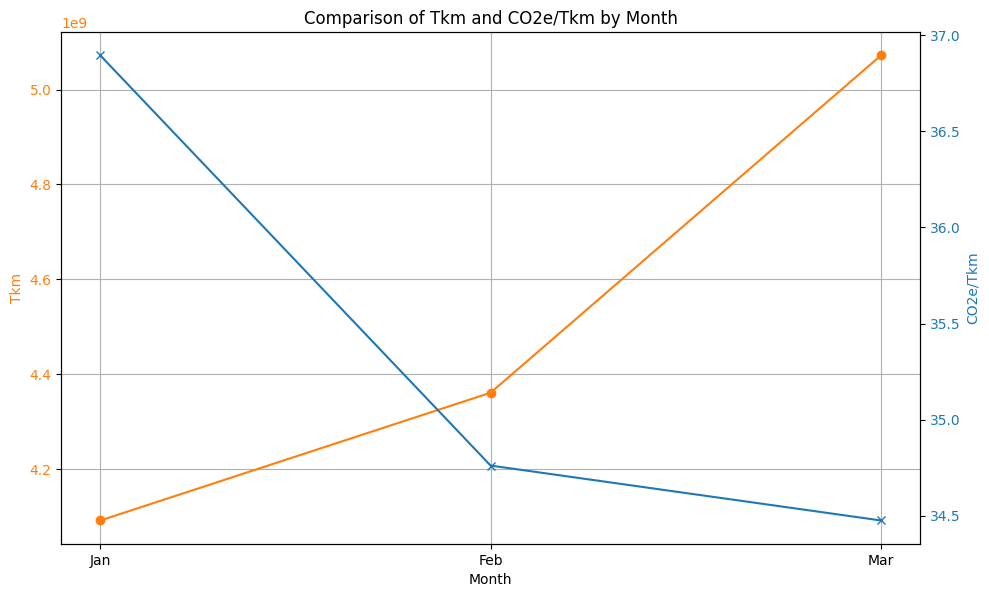

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# New data provided
data_new = {
    'Month': ['Jan', 'Feb', 'Mar'],
    'Tkm': [4091115022, 4360616872, 5072066637],
    'CO2e_per_Tkm': [36.89474149, 34.76106757, 34.47553776]
}
df_new = pd.DataFrame(data_new)

# Plotting Tkm and CO2e/Tkm to observe their relationship
fig, ax1 = plt.subplots(figsize=(10, 6))

# Setting Tkm color to orange
color_tkm = 'tab:orange'
ax1.set_xlabel('Month')
ax1.set_ylabel('Tkm', color=color_tkm)
ax1.plot(df_new['Month'], df_new['Tkm'], color=color_tkm, marker='o', label='Tkm')
ax1.tick_params(axis='y', labelcolor=color_tkm)
ax1.grid(True)  # Enable grid lines

# Setting CO2e/Tkm color to blue and using a twin axis
ax2 = ax1.twinx()
color_co2e = 'tab:blue'
ax2.set_ylabel('CO2e/Tkm', color=color_co2e)
ax2.plot(df_new['Month'], df_new['CO2e_per_Tkm'], color=color_co2e, marker='x', label='CO2e/Tkm')
ax2.tick_params(axis='y', labelcolor=color_co2e)

fig.tight_layout()
plt.title('Comparison of Tkm and CO2e/Tkm by Month')
plt.show()
